In [7]:
import pdb
import torch, os
import argparse, datetime
import gc,time
from tqdm import tqdm
import __init__



#from src.gp_cpab.src.transformation.gp_cpab import gp_cpab
#from src.gp_cpab.src.transformation.gp_cpab_tmp import gp_cpab
from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *

from src.models.trainer_tmp import vae_trainer
from src.unsuper.unsuper.data.mnist_data_loader import mnist_data_loader
from src.unsuper.unsuper.data.perception_data_loader import perception_data_loader
from src.unsuper.unsuper.helper.utility import model_summary
from src.models.encoder_decoder import get_encoder, get_decoder, get_list_encoders, get_list_decoders
from src.models import get_model

from src.seqsDataLoader import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

from src.models.experimental.vitae_ci_gp_detached_deepseq import vitae_ci_gp_no_deepseq
from src.models.experimental.deepsequence import DeepSequence

In [8]:
import argparse; import sys; sys.argv=['']; del sys

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=16, help='beta value for beta-vae model') #16
    
    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=10, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-3, help='learning rate for adam optimizer') # 1e-5 for 2 sequence deepseq 2 seqs other# 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction
    
    # Paths to use
    paths = parser.add_argument_group('Paths')
    
    # Best configuration for 2 sequence 3 aa example: tasks:4, prior:[0.0, 0.33, 0.33, 0.33], lengthscale=0.25, latent_dim=10, vitae conf: gp-gp
    #paths.add_argument('--path_orig', type=str, default="../data/orig_2seq_4a.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
    #paths.add_argument('--path_aligned_orig', type=str, default="../data/aligned_orig_2seq_4a.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
    
    paths.add_argument('--path_orig', type=str, default="../data/BLAT20.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_aligned_orig', type=str, default="../data/alignedBLAT20.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
    #paths.add_argument('--path_orig', type=str, default="../data/set10seqBLAT.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
    #paths.add_argument('--path_aligned_orig', type=str, default="../data/alignedset10seqBLAT.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
    
    #paths.add_argument('--path_orig', type=str, default="../data/BLAT2.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
    #paths.add_argument('--path_aligned_orig', type=str, default="../data/alignedBLAT2.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case') 
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report') 
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    #gpsetup.add_argument('--Task', type=int, default = 8, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143], help='multitaks-gp initialization') 
    gpsetup.add_argument('--Task', type=int, default = 4, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.33, 0.33, 0.33], help='multitaks-gp initialization') 
    #gpsetup.add_argument('--Task', type=int, default = 11, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], help='multitaks-gp initialization') #[0.0, 0.33, 0.33, 0.33] #[0.5, 0.5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.16, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [0,0.0004], help='noise constrain') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="cpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=60, help='number of tesselation cells') #6
    cpab.add_argument('--channels', type=int, default=60, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps') 

    # Hyper settings
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=10, help='dimensionality of the latent space') #5, 10
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')
    
    
    # Parse and return
    args = parser.parse_args()
    return args

In [9]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
#lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_aligned = std.parserinfo('path_aligned_orig')
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

#self.config, self.constrain, self.tasks, self.interpolation_type, self.option 
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])

#alphabets = ['-', 'A', 'D', 'G', 'I', 'L', 'R', 'S'] # for two long sequences
#alphabets = ['-', 'A', 'E', 'F', 'G', 'L', 'Q', 'R', 'S', 'T', 'V'] # ['-', 'L', 'Q', 'R'] #-> for 10 sequences case
alphabets = ['-', 'A', 'D', 'L'] #-> for 4 sequences
#alphabets = ['-', 'L', 'Q', 'R'] #-> pairwise sequence alignment
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_2TOYSEQS.pth'
logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_BLAT20.pth'


print('Ok')

None
Ok


In [10]:
from src.gp_cpab.src.extra import experiment_utilities
from src.dataLoaderDiffeo import datasetLoader

# Raw Sequences, to see if we can align the sequences somehow

c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)
dataset_msa = seqsDatasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True)
#x1 = dataset_msa.prot_space
dataset_aligned_msa = seqsDatasetLoader(pathBLAT_data = path_aligned, alphabet = alphabets, enable_variable_length=True)

'''--------------------------------------------------------------------------------------------------------------------------'''
'''dataset_msa.prot_space = replace_target_token_gaps(dataset_msa.prot_space, c2i, '-')[:,:,1:]
dataset_aligned_msa.prot_space = replace_target_token_gaps(dataset_aligned_msa.prot_space, c2i, '-')[:,:,1:]
alphabets=['L','Q','R']
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)'''
'''--------------------------------------------------------------------------------------------------------------------------'''

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

# initially the dimension is [448, 34, 21]. However as it is necesary to ignore 
# the batch size, I just create a tuple, by taking just the last 2 components from the size
trainloader, testloader = Sequence_Data_Loader(dataset_msa, dataset_test=None, batch_size=batches)
trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, dataset_test=None, batch_size=batches)
#trainloader2, testloader2 = Sequence_Data_Loader(dataset_msa2, dataset_test=None, batch_size=batches)


seq_size = ( [*dataset_msa.prot_space.shape][1:])

Loading data


In [11]:
# Loading BLAT dataset
deepseq = DeepSequence(seq_size, args.latent_dim, alphabets, device = 'cpu')
optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr)
loss_function = LossFunctionsAlternatives()
pretrained_deepseq_path = logdir + "/" + outmodel_name
check_parameter_historic = []

if os.path.isfile(pretrained_deepseq_path):
    print ("Loading Deformation Model...")
    deepseq.load_state_dict( torch.load(pretrained_deepseq_path) )
    print ("Loaded")
    #for param in deepseq.parameters():
    #    param.requires_grad = False
else:
    deepseq.training_representation(trainloader_pretrainer, loss_function, optimizer_deepseq,args.n_epochs, 1, logdir=logdir, out_modelname=outmodel_name )
    #check_parameter_historic = list(deepseq.parameters())
    #for param in deepseq.parameters():
    #    param.requires_grad = False

deepseq(dataset_msa.prot_space)

Epoch 500/500: 100%|██████████| 4/4 [00:00<00:00, 35.24samples/s, loss=11.9] 


Total train time 155.54678416252136


(tensor([[[1.2117e-06, 1.0000e+00, 1.1118e-06, 1.1522e-06],
          [4.5086e-04, 3.2471e-06, 9.9954e-01, 2.4313e-06],
          [4.8038e-05, 1.1790e-06, 1.0409e-06, 9.9995e-01],
          [7.2891e-06, 9.9999e-01, 5.3428e-07, 7.1371e-07]],
 
         [[8.6227e-05, 9.9976e-01, 8.0774e-05, 7.4328e-05],
          [2.3672e-01, 1.1192e-03, 7.6134e-01, 8.1654e-04],
          [8.3764e-05, 3.7462e-05, 3.3512e-05, 9.9985e-01],
          [8.5464e-03, 9.9094e-01, 2.3693e-04, 2.8021e-04]],
 
         [[5.4106e-07, 1.0000e+00, 3.6841e-07, 3.6073e-07],
          [1.6004e-03, 6.6934e-06, 9.9839e-01, 4.9360e-06],
          [1.1478e-08, 2.2194e-08, 1.4414e-08, 1.0000e+00],
          [2.3290e-01, 7.6701e-01, 3.8869e-05, 4.7162e-05]],
 
         [[1.1254e-05, 9.9997e-01, 8.5865e-06, 9.0935e-06],
          [5.5245e-01, 4.8179e-04, 4.4670e-01, 3.7044e-04],
          [5.3785e-09, 1.3680e-07, 1.1914e-07, 1.0000e+00],
          [9.6029e-01, 3.9494e-02, 9.8646e-05, 1.1305e-04]]],
        grad_fn=<SoftmaxBackw

In [ ]:
'''ff=deepseq(trainloader.dataset.prot_space, 1, 1, 1)
print(trainloader.dataset.prot_space)
print(ff[0])
BLAT = deepseq.load_BLAT('../data/BLAT_data_df.pkl')'''


"ff=deepseq(trainloader.dataset.prot_space, 1, 1, 1)\nprint(trainloader.dataset.prot_space)\nprint(ff[0])\nBLAT = deepseq.load_BLAT('../data/BLAT_data_df.pkl')"

In [12]:
import time
def fit_VITAE_with_pretrained_DeepSeq(trainloader, optimizer, model, DS, n_epochs=10, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10000, **kargs):
        """ Fits the supplied model to a training set 
        Arguments:
            trainloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the training data
            n_epochs: integer, number of epochs to run
            warmup: integer, the KL terms are weighted by epoch/warmup, so this
                number determines the number of epochs before the KL-terms are 
                fully activated in the loss function
            logdir: str, where to store the results
            testloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the test data
            eq_samples: integer, number of equality samples which the expectation
                is calculated over
            iw_samples: integer, number of samples the mean-log is calculated over
            eval_epoch: how many epochs that should pass between calculating the
                L5000 loglikelihood (very expensive to do)
        """

        # Assert that input is okay
        assert isinstance(trainloader, torch.utils.data.DataLoader), '''Trainloader
            should be an instance of torch.utils.data.DataLoader '''
        assert warmup <= n_epochs, ''' Warmup period need to be smaller than the
            number of epochs '''
    
        # Print stats
        print('Number of training points: ', len(trainloader.dataset.prot_space))
        if testloader: print('Number of test points:     ', len(testloader.dataset))
        
        loss_function = LossFunctionsAlternatives()


        # Main loop
        start = time.time()
        for epoch in range(1, n_epochs+1):
            progress_bar = tqdm(desc='Epoch ' + str(epoch) + '/' + str(n_epochs), 
                                total=len(trainloader.dataset), unit='samples')
            train_loss = 0
            # Training loop
            #self.model.train()
            for i, data in enumerate(trainloader):
                # Zero gradient
                optimizer.zero_grad()
                #import pdb;pdb.set_trace()
                # Feed forward data
                data = data.to(torch.float32).to(device)

                switch = 1.0 if epoch > warmup else 0.0
                out = model(data, DS, eq_samples, iw_samples, switch)
                
                # Calculat loss
                loss = loss_function(method = 'CE', input = out[0], target = data, forw_per=(0,2,1))  - out[7]
                #loss = loss_function(method = 'JSD', input = out[0], target = data, forw_per=(0,2,1)) # - out[7]

                
                # Backpropegate and optimize
                loss.backward()
                optimizer.step()
                
                # Write to consoeeeddddddddwwww######hhhdffffffffffsssswqqq#l#
                progress_bar.update(data.size(0))
                progress_bar.set_postfix({'loss': loss.item()})
                
                # Save to tensorboard
                iteration = epoch*len(trainloader) + i
                
                gc.collect()
                torch.cuda.empty_cache()

            progress_bar.close()
        
        print('Total train time', time.time() - start)
        #import pdb;pdb.set_trace()
        # Save the embeddings

In [13]:

# Construct model
# I do not add the pretrained deepsequence module to avoid 
# the backpropagation of such module during the optimization
model = vitae_ci_gp_no_deepseq(
                    input_shape = seq_size, #img_size,
                    config = std, 
                    latent_dim = args.latent_dim, 
                    encoder = get_encoder( args.ed_type.split(",")[0] ), 
                    decoder = get_decoder( args.ed_type.split(",")[1] ),
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    trans_parameters = ( [window_grid], device, gp_params ) )

#model.get_deepsequence_module(deepseq)

# Optimizer
opt = torch.optim.AdamW(model.parameters(), lr=1e-3) #, weight_decay=1e-6) #lr=1e-3 and weigh_dacay1e-6 - 1e-7 in that range is working for such examples
model_name = '/trained_model_softmax.pt'

fit_VITAE_with_pretrained_DeepSeq(trainloader, opt, model, deepseq, n_epochs=1000, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10)

Number of training points:  4


Epoch 1/1000:   0%|          | 0/4 [00:00<?, ?samples/s]/workspaces/Explicit_Disentanglement_Proteins/src/models/experimental/vitae_ci_gp_detached_deepseq.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean_no_grad, requires_grad=True)
/workspaces/Explicit_Disentanglement_Proteins/src/models/experimental/vitae_ci_gp_detached_deepseq.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(x_var_no_grad, requires_grad=True)
Epoch 1000/1000: 100%|██████████| 4/4 [00:00<00:00,  5.90samples/s, loss=14.7]

Total train time 520.5226984024048


/workspaces/Explicit_Disentanglement_Proteins/src/models/experimental/vitae_ci_gp_detached_deepseq.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean_no_grad, requires_grad=True)
/workspaces/Explicit_Disentanglement_Proteins/src/models/experimental/vitae_ci_gp_detached_deepseq.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(x_var_no_grad, requires_grad=True)


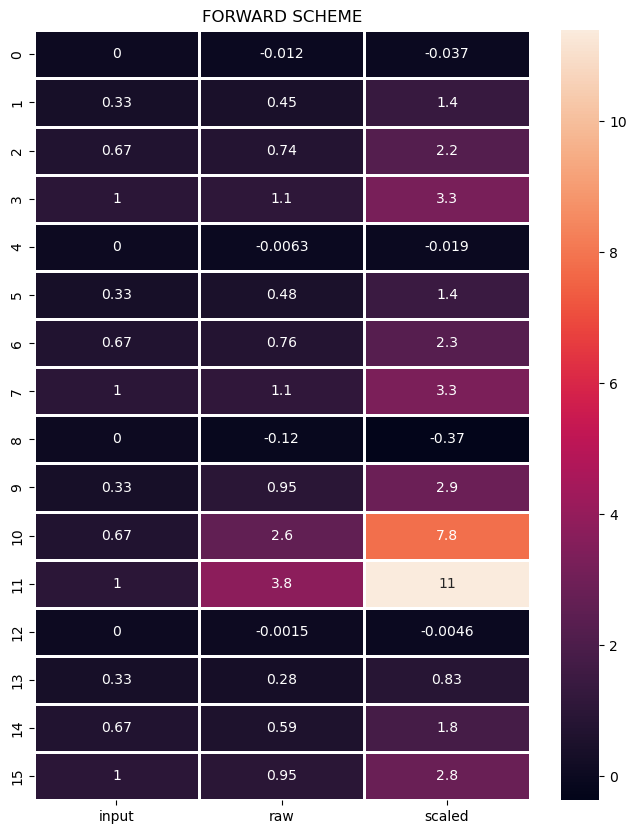

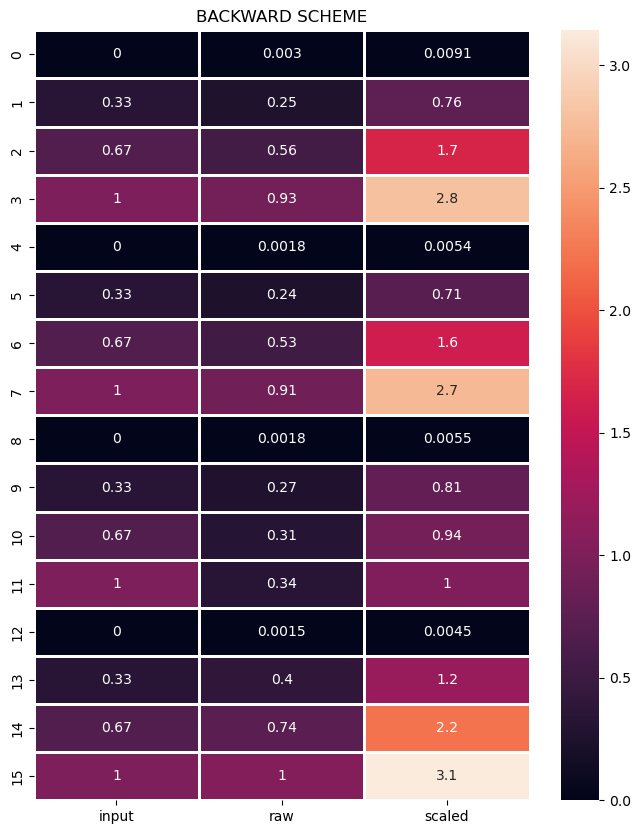

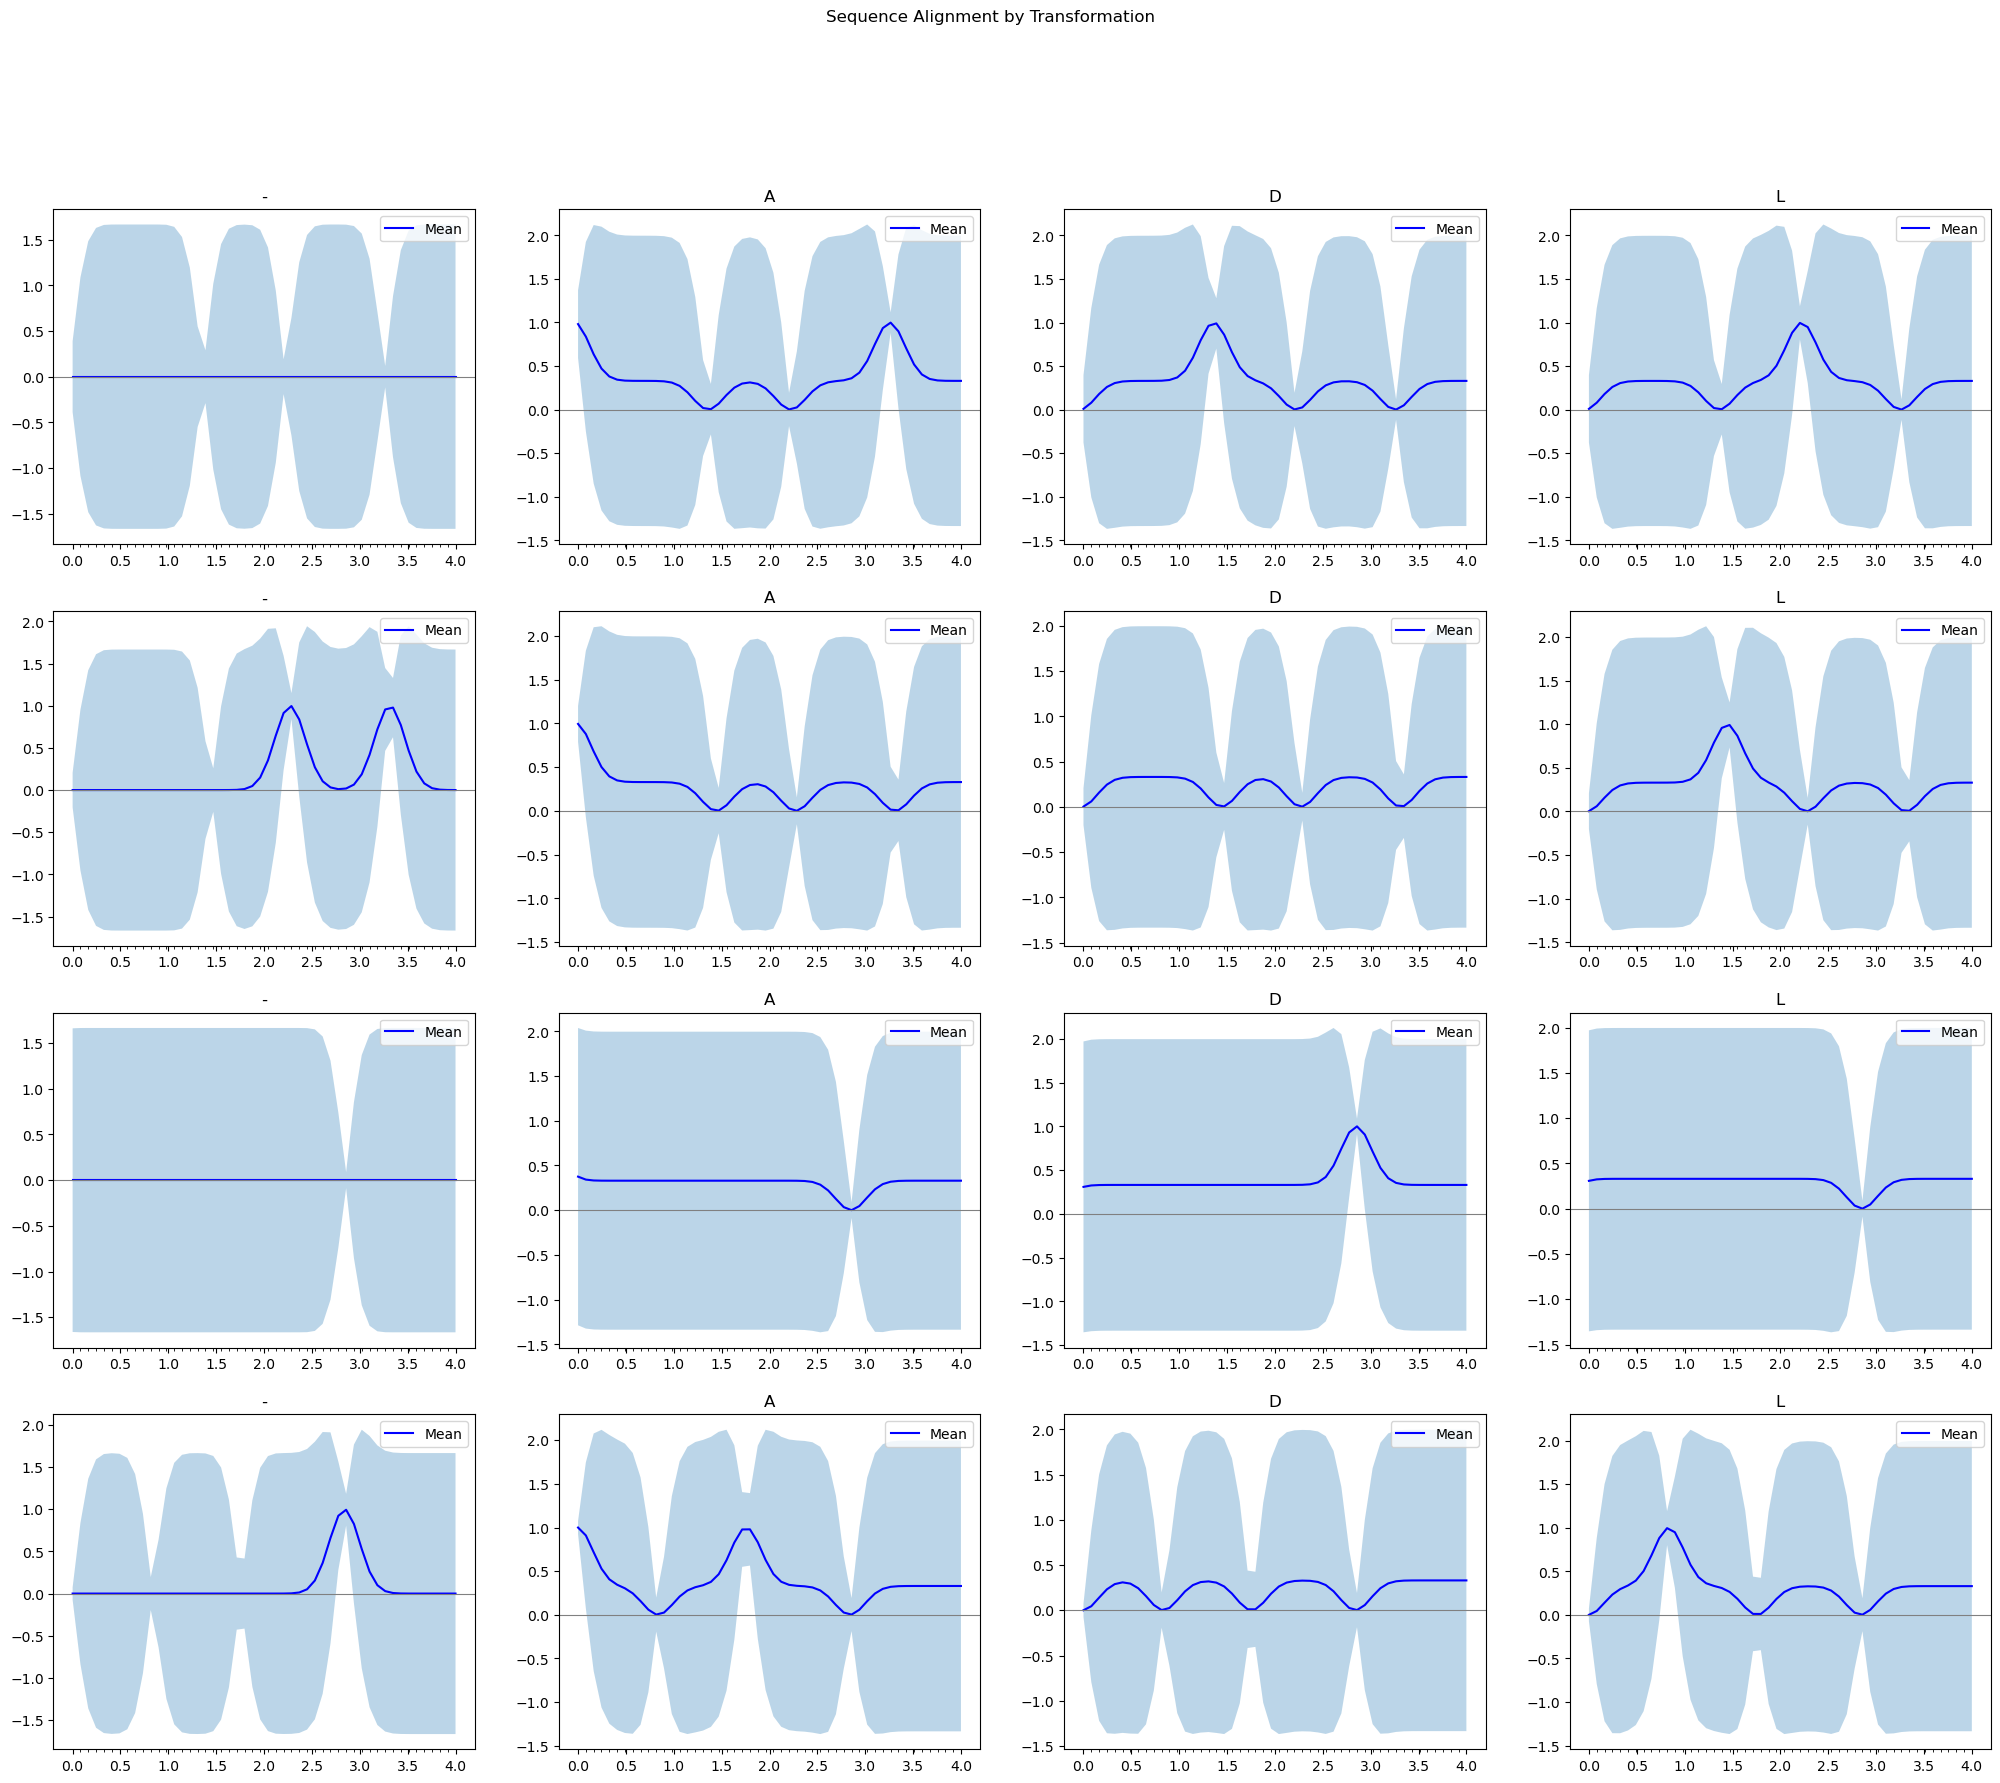

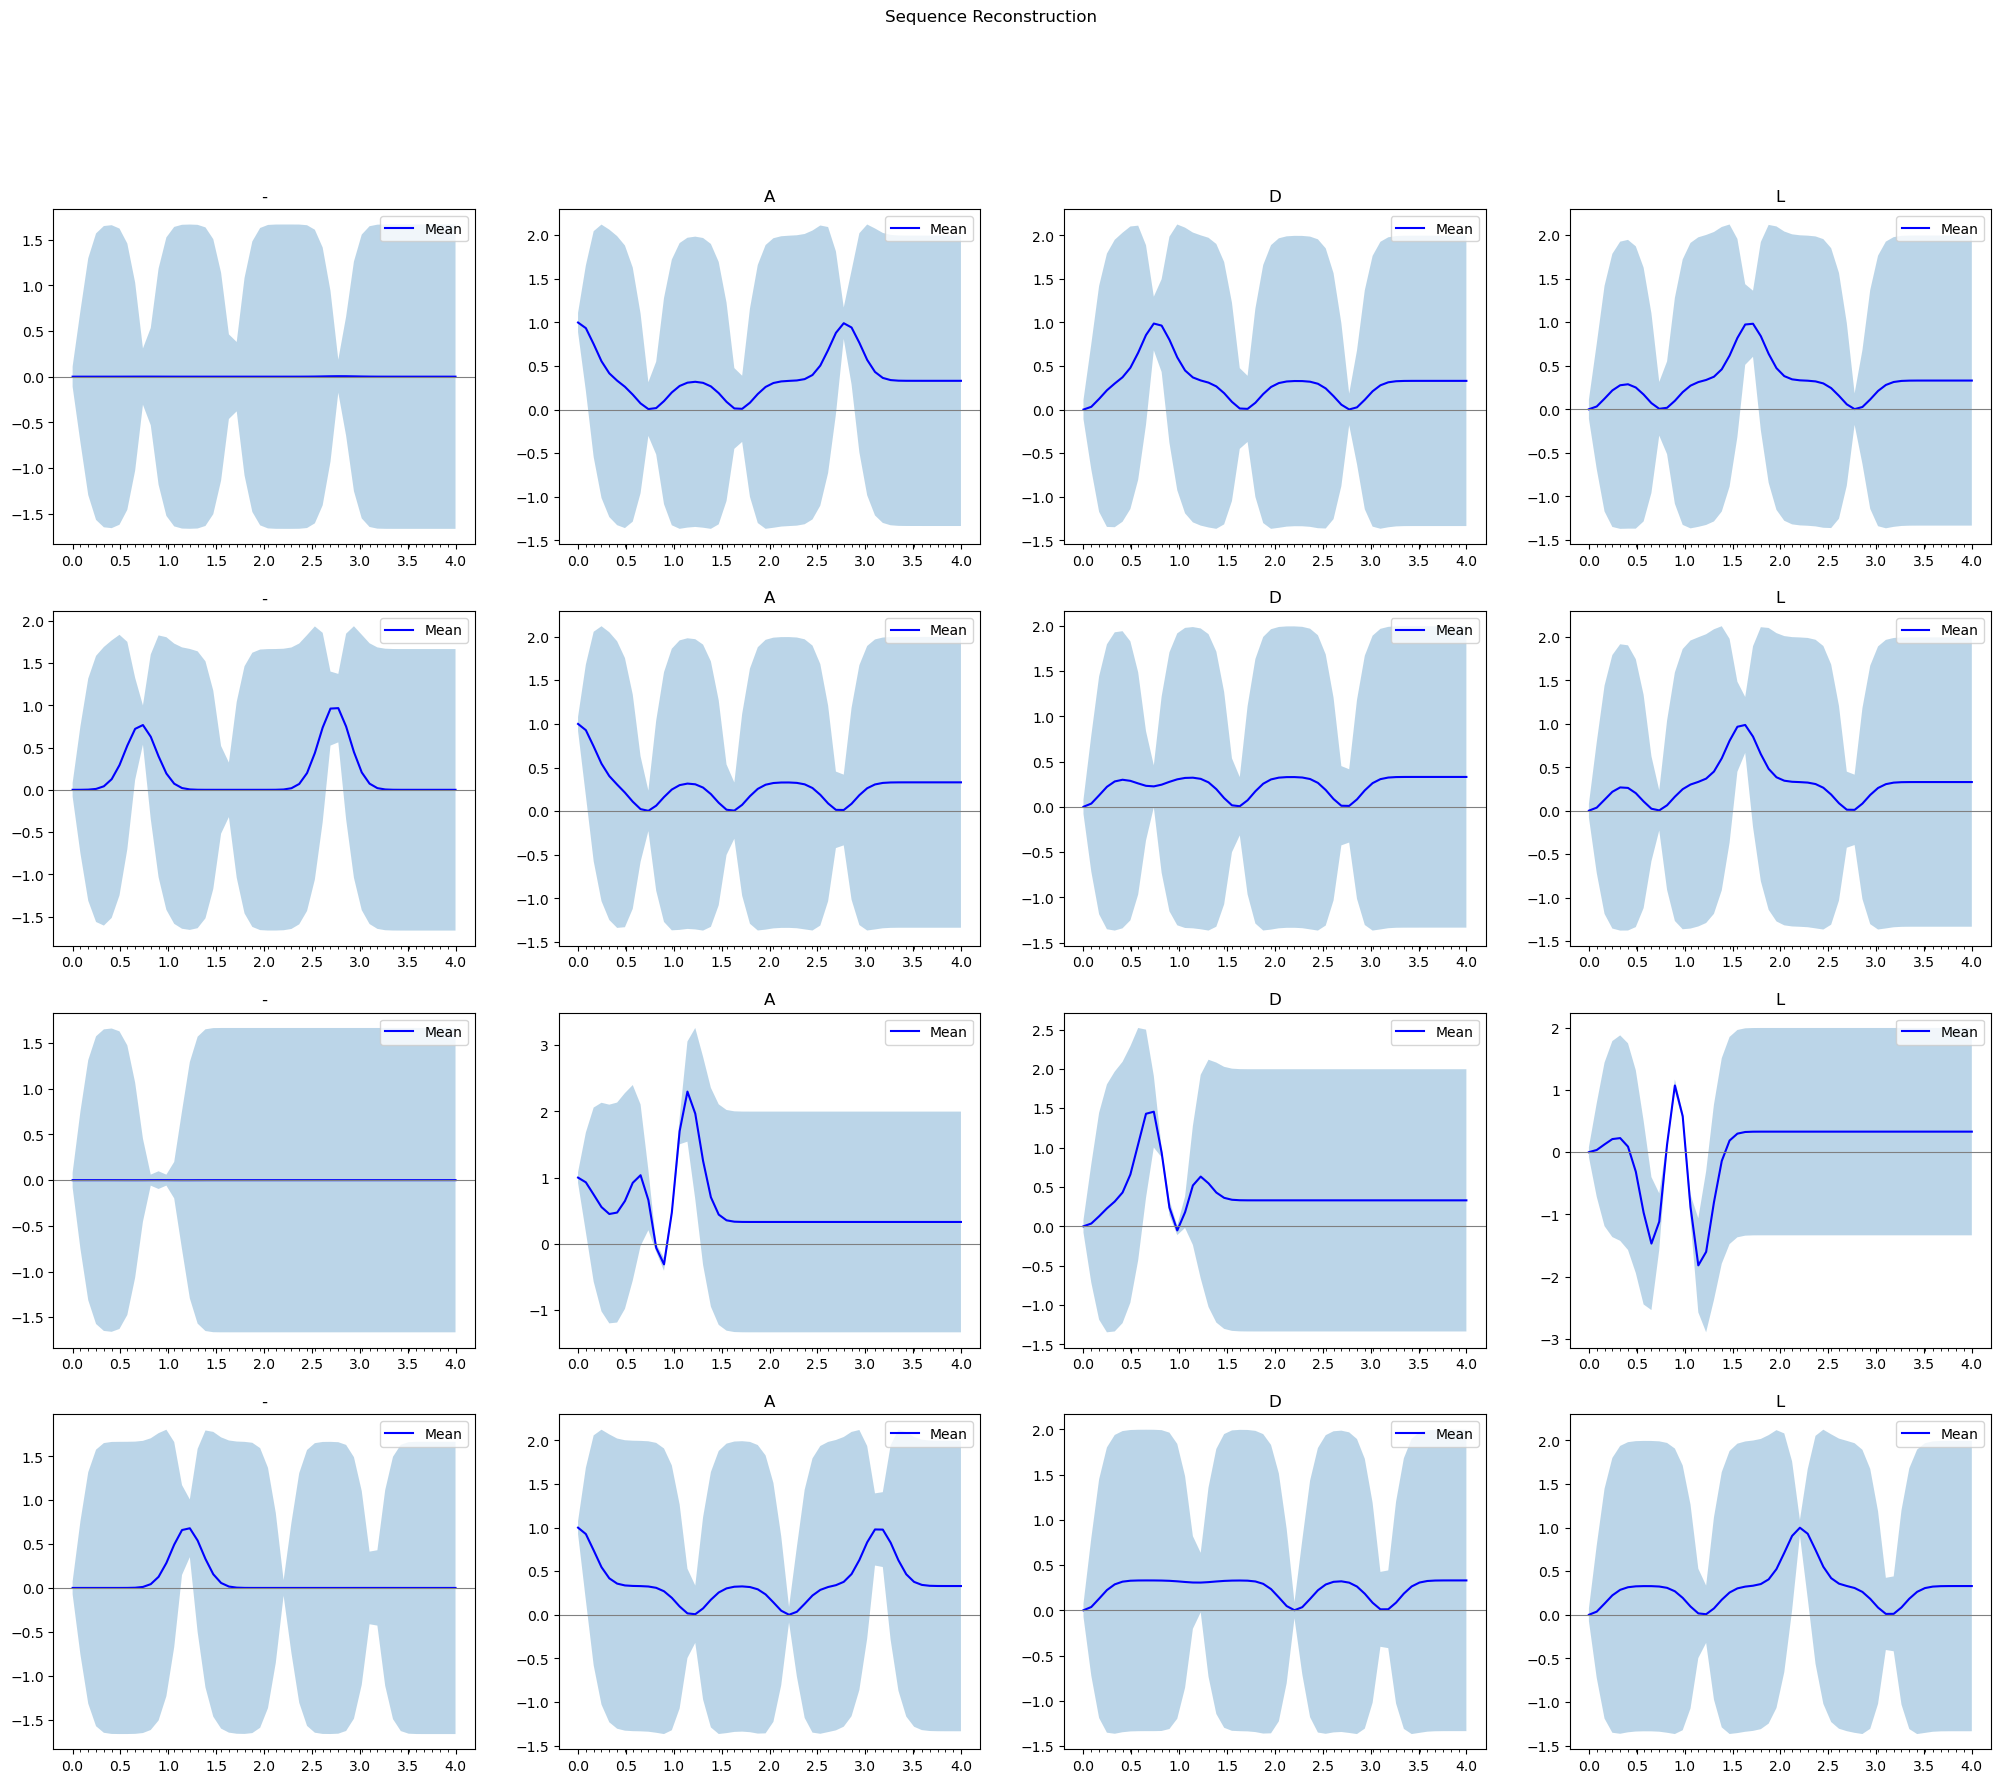

In [21]:
import matplotlib.pyplot as plt
import src.gp_cpab.src.extra.utilities as ut
import matplotlib.gridspec as gridspec
import logomaker 


def get_GPinterpolation(TT, theta, Y, Ug,  n_batch, grid_length_for_GP, seq_len):
    grids_trans_out = (TT.transform_grid(TT.grid,theta)*(seq_len - 1)).squeeze(1)
    # creating the likelihood for interpolation
    batch_Multitask_model, batch_multitask_likelihood = TT.sets_MultioutputGP_per_batches(grids_trans_out, Y, n_batch)
    # To get distribution over Posteriors
    trans_data, _, \
            lower,upper  = TT.predict_operation(Ug, batch_Multitask_model, batch_multitask_likelihood  )
    trans_data = torch.reshape(trans_data, (n_batch, grid_length_for_GP, Y.shape[2]))
    lower = torch.reshape( lower, (n_batch, grid_length_for_GP, Y.shape[2]) )
    upper = torch.reshape( upper, (n_batch, grid_length_for_GP, Y.shape[2]) )

    return grids_trans_out, trans_data, lower, upper

def plot_GP_components_per_seq(Ug, gT, Trdata, Lw, Up, nrows, ncols, alphabets, title, fig):

    for j, axs in enumerate(fig.axes[(nrows-1)*ncols : nrows*ncols]):
        axs.plot( Ug.flatten().detach().numpy(), Trdata[:,j].detach().numpy(), 'b' )
        axs.fill_between(Ug.flatten().detach().numpy(), Lw[:,j].detach().numpy(),  Up[:,j].detach().numpy(), alpha=0.3)
        axs.legend([ 'Mean'])
        axs.set_xticks( Ug.flatten().detach().numpy(), minor= True )
        axs.axhline(0, color='grey', linewidth=0.8)
        axs.set_title(alphabets[j])
    
    #fig.tight_layout()
    
 
def create_gridSpec_graphs(ncols=4,nrows=2,figsize=(25,12)):
    fig = plt.figure(figsize=figsize) #(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    for i in range(0, nrows):
        for j in range(0,ncols):
            fig.add_subplot(gs[i, j])
    return fig, gs

def plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig2):
    for cont,(U,gT, Trdata,Lw,Up) in enumerate(list(zip(Ug,grids_trans_out, trans_data,lower,upper))):
        title='sequence {0}'.format(cont+1)
        plot_GP_components_per_seq(U, gT, Trdata, Lw, Up, cont+1, Trdata.shape[1], alphabets=alphabets, title=title, fig = fig2)

def heatmap_from_tensor_tmp(data, alphabet, title):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    figure, ax = plt.subplots(figsize=(8,10))
    #ax = plt.axes()
    px = pd.DataFrame(data, columns=alphabet)
    ff=sns.heatmap(px, linewidth=1, linecolor='w', annot=data, ax = ax)
    ax.set_title(title)
    plt.show()

def plot_msa_from_preds(ts_aligned, alphabet, figsize = (5,4), show_axis=True):
    fig, gs = create_gridSpec_graphs(ncols=1,nrows=ts_aligned.shape[0], figsize=figsize); fig.suptitle('MSA', fontsize='large')

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabet] 
    for cont, x_aligned in enumerate(ts_aligned):
        domain_info_df = df_construction_aas([ x_aligned.unsqueeze(0).detach().numpy() ], x_aligned.unsqueeze(0).shape, alphabets_logo)
        
        if show_axis == False:
            fig.axes[cont].get_xaxis().set_visible(False)
            fig.axes[cont].get_yaxis().set_visible(False)

        logomaker.Logo(domain_info_df,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[cont],
                          figsize=figsize, show_spines=False)



# recon_data_train = model(dataset_msa.prot_space, deepseq)
def get_GP_behavior_from_model_alignment(data,model, DS, len_grid = 13 , alphabets=['-','L','Q','R']):
    model.eval()
    Y = data
    recon_data_train = model(data, DS)

    x1_trans = recon_data_train[5]

    out_DS_before_dir_trans = DS(x1_trans)[0]

    TT=model.stn.st_gp_cpab
    TT.interpolation_type = 'GP'
    grid_length_for_GP = len_grid


    #get the transformation from Big model
    _, theta = model.sample_only_trans(Y)
    seq_len = Y.shape[1]; n_batch = Y.shape[0]

    ''' info about initial deformation '''
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
    initialTT_raw = TT.grid
    initialTT_inv = TT.transform_grid(TT.grid,-theta)
    initialTT_dir = TT.transform_grid(TT.grid,theta)
    forward = torch.stack([initialTT_raw.flatten() ,initialTT_inv.flatten(), (initialTT_inv*(x1_trans.shape[1]-1)).flatten() ]).T
    backward = torch.stack([initialTT_raw.flatten() ,initialTT_dir.flatten(), (initialTT_dir*(x1_trans.shape[1]-1)).flatten() ]).T
    heatmap_from_tensor_tmp(forward.detach().numpy(), ['input','raw','scaled'], 'FORWARD SCHEME' )
    heatmap_from_tensor_tmp(backward.detach().numpy(), ['input','raw','scaled'], 'BACKWARD SCHEME' )
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

    # grid creations and deformations based on theta estimated from big model

    Ug=TT.uniform_meshgrid((grid_length_for_GP,grid_length_for_GP)).repeat(n_batch,1,1)*(seq_len)
    
    grids_trans_out, trans_data, lower, upper = get_GPinterpolation(TT, -theta, Y, Ug, n_batch, grid_length_for_GP, seq_len)
    grids_dir_trans_out, dir_trans_data, lower_dir, upper_dir = get_GPinterpolation(TT, theta, out_DS_before_dir_trans, Ug, n_batch, grid_length_for_GP, seq_len)

    ncols= grids_trans_out.shape[-1]; nrows = Ug.shape[0]
    fig, gs = create_gridSpec_graphs(ncols=ncols,nrows=nrows, figsize=(25,20)); fig.suptitle('Sequence Alignment by Transformation', fontsize='large')
    figdir, gsdir = create_gridSpec_graphs(ncols=ncols,nrows=nrows,figsize=(25,20)); figdir.suptitle('Sequence Reconstruction', fontsize='large')
    
    plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig)
    plot_GP_components_alignment_channel(Ug,grids_dir_trans_out, dir_trans_data,lower_dir,upper_dir, figdir)


get_GP_behavior_from_model_alignment(trainloader.dataset.prot_space,model, deepseq, len_grid = 50 )

/workspaces/Explicit_Disentanglement_Proteins/src/models/experimental/vitae_ci_gp_detached_deepseq.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean_no_grad, requires_grad=True)
/workspaces/Explicit_Disentanglement_Proteins/src/models/experimental/vitae_ci_gp_detached_deepseq.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(x_var_no_grad, requires_grad=True)


Done
tensor([[[ 0.0000e+00,  9.9961e-01,  1.9282e-04,  1.9282e-04],
         [ 0.0000e+00,  2.5198e-04,  9.9949e-01,  2.5198e-04],
         [ 0.0000e+00,  3.5211e-04,  3.5211e-04,  9.9929e-01],
         [ 0.0000e+00,  9.9767e-01,  1.1463e-03,  1.1463e-03]],

        [[ 3.7329e-41,  9.4287e-01,  2.8138e-02,  2.8138e-02],
         [-9.5443e-18,  3.3000e-01,  3.3000e-01,  3.3000e-01],
         [-1.4527e-09,  8.9478e-04,  8.9478e-04,  9.9818e-01],
         [ 9.9923e-01,  2.5511e-04,  2.5511e-04,  2.5511e-04]],

        [[ 0.0000e+00,  9.9919e-01,  3.9658e-04,  3.9658e-04],
         [ 0.0000e+00,  9.8836e-03,  9.7993e-01,  9.8836e-03],
         [-2.2928e-28,  3.3000e-01,  3.3000e-01,  3.3000e-01],
         [-1.2162e-20,  9.9950e-01,  2.4503e-04,  2.4503e-04]],

        [[ 0.0000e+00,  9.2503e-01,  3.6925e-02,  3.6925e-02],
         [ 2.3126e-34,  3.3000e-01,  3.3000e-01,  3.3000e-01],
         [ 9.1121e-26,  3.0791e-03,  3.0791e-03,  9.9375e-01],
         [-5.4753e-17,  9.8795e-01,  5.9328e

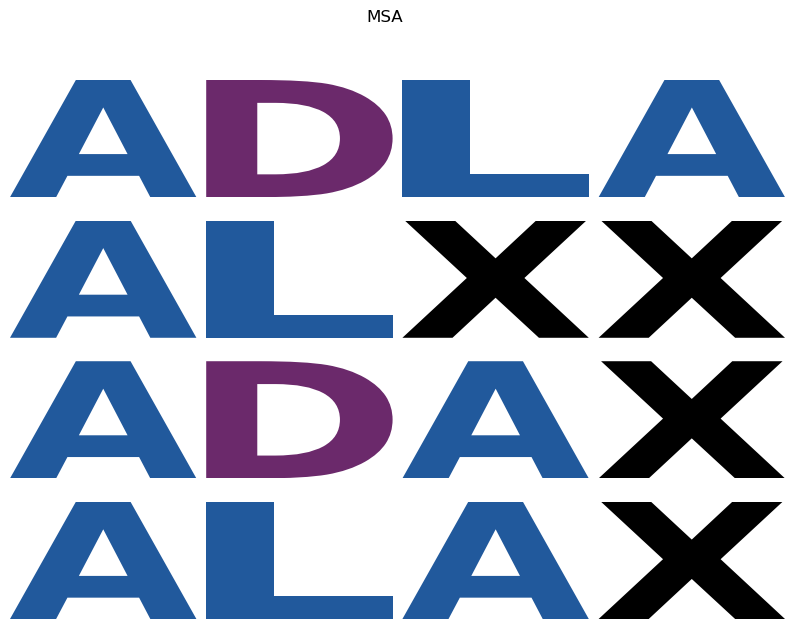

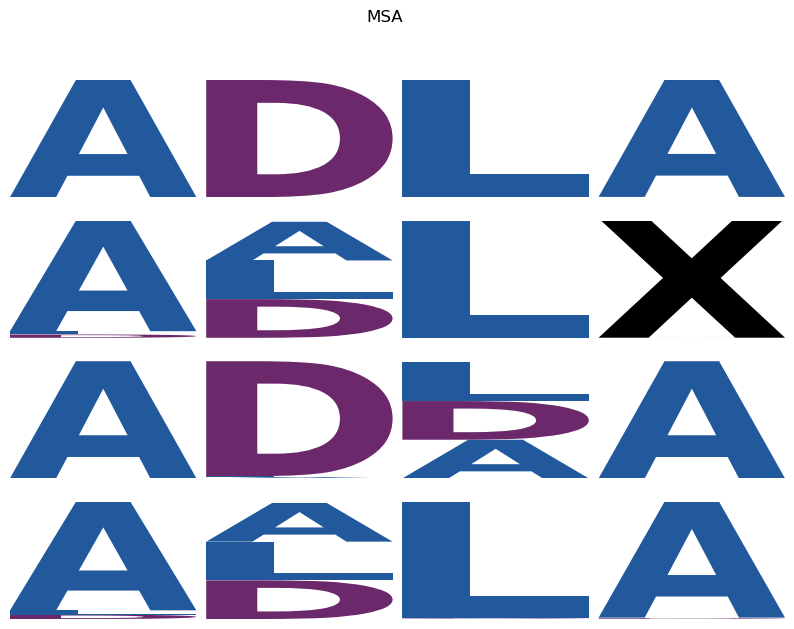

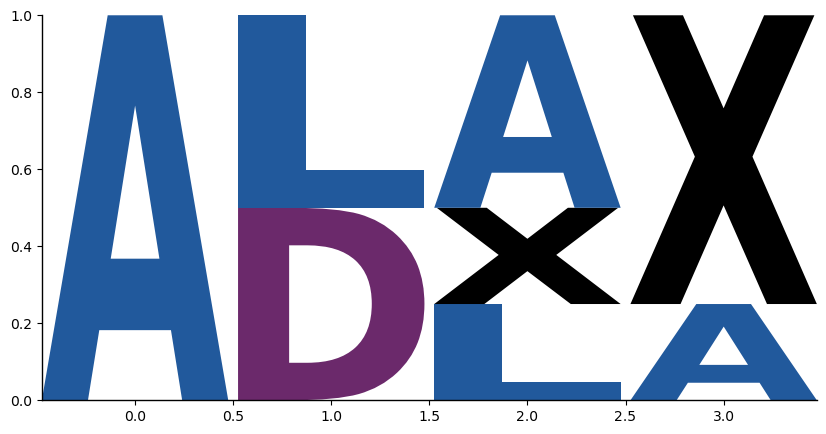

 ___    ___    ___    _____  _   _  ___   _____  ___    _   _  ___   _____  _ 
|  _`\ (  _`\ (  _`\ (  _  )( ) ( )(  _`\(_   _)|  _`\ ( ) ( )(  _`\(_   _)(_)
| (_) )| (_(_)| ( (_)| ( ) || `\| || (_(_) | |  | (_) )| | | || ( (_) | |  | |
| ,  / |  _)_ | |  _ | | | || , ` |`\__ \  | |  | ,  / | | | || |  _  | |  | |
| |\ \ | (_( )| (_( )| (_) || |`\ |( )_) | | |  | |\ \ | (_) || (_( ) | |  | |
(_) (_)(____/'(____/'(_____)(_) (_)`\____) (_)  (_) (_)(_____)(____/' (_)  (_)
                                                                              
                                                                              
 _____  _   _ 
(  _  )( ) ( )
| ( ) || `\| |
| | | || , ` |
| (_) || |`\ |
(_____)(_) (_)
              
              



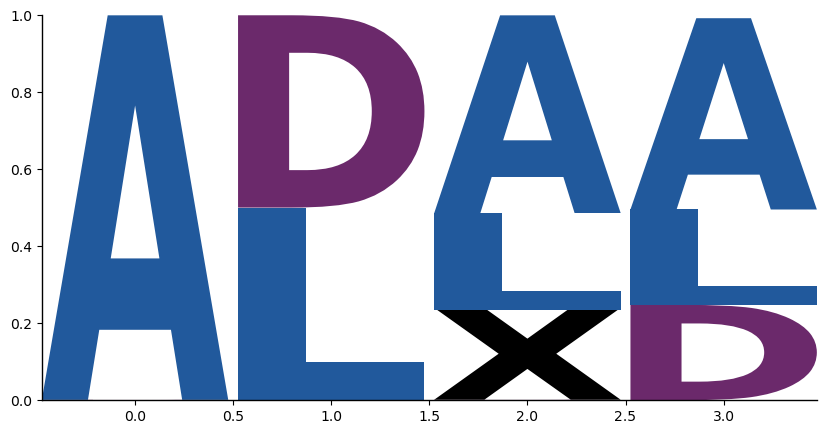

 _____  _      _  ___    _   _         ___    _   _  _____ 
(  _  )( )    (_)(  _`\ ( ) ( )/'\_/`\(  _`\ ( ) ( )(_   _)
| (_) || |    | || ( (_)| `\| ||     || (_(_)| `\| |  | |  
|  _  || |  _ | || |___ | , ` || (_) ||  _)_ | , ` |  | |  
| | | || |_( )| || (_, )| |`\ || | | || (_( )| |`\ |  | |  
(_) (_)(____/'(_)(____/'(_) (_)(_) (_)(____/'(_) (_)  (_)  
                                                           
                                                           



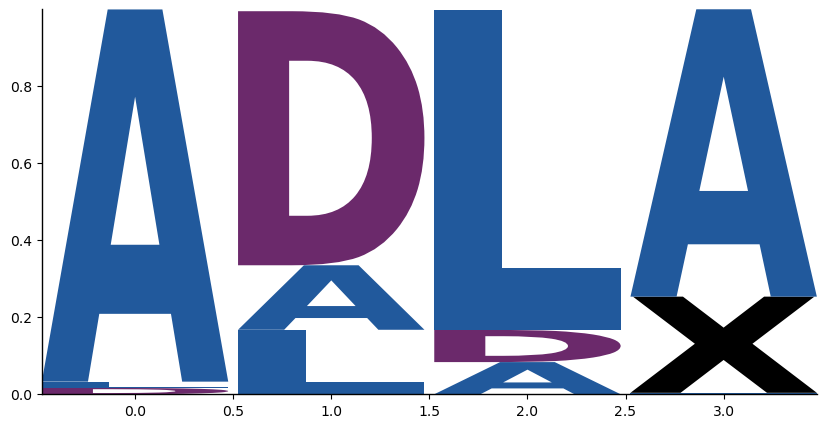

In [22]:
model.eval()
recon_data_train = model(dataset_msa.prot_space, deepseq)


print('Done')

from pyfiglet import Figlet
f = Figlet(font='puffy' ) #slant

print(recon_data_train[5])
alignment = recon_data_train[5]

plot_msa_from_preds(trainloader.dataset.prot_space, alphabets, figsize=(10,7), show_axis=False)
plot_msa_from_preds(alignment, alphabets, figsize=(10,7), show_axis=False)



print(f.renderText('INPUT'))
plot_logos_probs(dataset_msa.prot_space, alphabets)

print(f.renderText('RECONSTRUCTION'))
plot_logos_probs(recon_data_train[0], alphabets)

print(f.renderText('ALIGNMENT'))
plot_logos_probs(recon_data_train[5], alphabets)

